---

# University of Liverpool

## COMP534 - Applied AI

---

This notebook is associated with Assignment 2. Use it to complete the assignment by following the instructions provided in each section. Each section includes a text cell outlining the requirements. For additional details, refer to Canvas.

If you are using Google Colab, you can use the cell below to download and unzip the data.
If you are running on your computer, you will need to do this yourself.

In [ ]:
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip UCMerced_LandUse.zip

Use this first cell to import the necessary libraries.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms
import torchvision.models as models

# 1. **Data Management**


In this part, you need to:

1.  define your experimental protocol (such as k-fold, cross validation, etc)
2.	create the dataloader to load the data; remember to include here any normalization, data augmentation, or other technique used to pre-process the data


In [2]:
# Define transformations (normalization and augmentation)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
data_dir = r'UCMerced_LandUse/Images' 
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Split dataset into train (70%), validate (10%) and test (20%)
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - (train_size + val_size)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


---

# 2. **Neural Networks**

Here, you need to:

1.	propose your own Convolutional Neural Network (CNN) to tackle the problem;
2.	define at least one existing CNN (such as AlexNet, VGG, ResNet, DenseNet, etc) to tackle the problem;
3.	define the necessary components to train the networks (that is, loss function, optimizers, etc);
4.	train your proposed architecture from scratch using your training set;
5.	train the existing architecture using at least 2 different strategies (i.e., trained from scratch, fine-tuning, feature extractor, etc);
6.	for all training procedures, separately plot the loss and accuracy with respect to the epoch/iteration.



In [3]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Define a function to train our models and retain the necessary information

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Compute average training loss and accuracy
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Evaluation phase
        model.eval()
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == labels).sum().item()
                total_test += labels.size(0)

        # Compute average test loss and accuracy
        epoch_test_loss = running_test_loss / len(test_loader)
        epoch_test_acc = 100 * correct_test / total_test
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | "
              f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%")

    return train_losses, test_losses, train_accuracies, test_accuracies

In [5]:
# Define a function to plot the loss curve
def plot_loss(model_name, train_losses, test_losses):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss', linestyle='dashed')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Test Loss for ' + model_name)

    plt.show()


# Define a function to plot the accuracy curve
def plot_acc(model_name, train_accuracies, test_accuracies):
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy', linestyle='dashed')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training vs Test Accuracy for ' + model_name)

    plt.show()

Epoch 1/10 - Train Loss: 2.2251, Train Acc: 55.44% | Test Loss: 3.7899, Test Acc: 47.14%
Epoch 2/10 - Train Loss: 0.5845, Train Acc: 83.47% | Test Loss: 1.1183, Test Acc: 79.05%
Epoch 3/10 - Train Loss: 0.4059, Train Acc: 87.96% | Test Loss: 0.5928, Test Acc: 80.48%
Epoch 4/10 - Train Loss: 0.3000, Train Acc: 90.95% | Test Loss: 0.5320, Test Acc: 87.62%
Epoch 5/10 - Train Loss: 0.2553, Train Acc: 92.79% | Test Loss: 0.5095, Test Acc: 84.76%
Epoch 6/10 - Train Loss: 0.2695, Train Acc: 91.63% | Test Loss: 0.4048, Test Acc: 87.62%
Epoch 7/10 - Train Loss: 0.1799, Train Acc: 95.03% | Test Loss: 0.9513, Test Acc: 77.14%
Epoch 8/10 - Train Loss: 0.2356, Train Acc: 93.13% | Test Loss: 0.6377, Test Acc: 86.19%
Epoch 9/10 - Train Loss: 0.2152, Train Acc: 94.01% | Test Loss: 0.2642, Test Acc: 89.52%
Epoch 10/10 - Train Loss: 0.1615, Train Acc: 96.05% | Test Loss: 0.2515, Test Acc: 92.38%


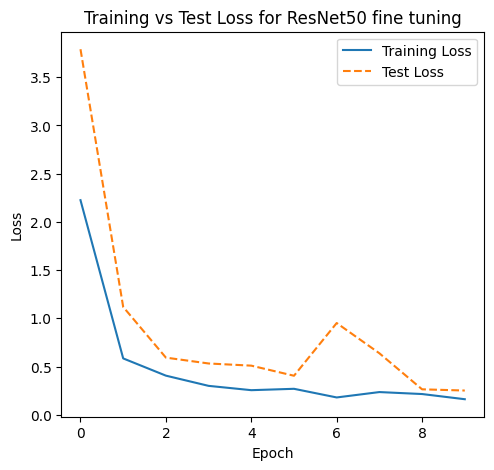

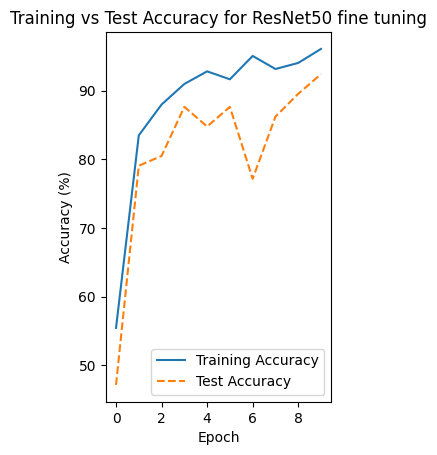

In [ ]:
# ResNet50 with fine tuning implementation

# Load ResNet50 without pre-trained weights
ResNet_FT = models.resnet50(weights=None)

# Load the pre-trained weights from the downloaded file
ResNet_FT.load_state_dict(torch.load('resnet50-19c8e357.pth', map_location=device, weights_only= False))

# Move the model to the desired device (GPU/CPU)
ResNet_FT = ResNet_FT.to(device)

# Define components
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ResNet_FT.parameters(), lr=1e-3)

# Train the ResNet50 fine tuning
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    ResNet_FT, train_loader, val_loader, criterion, optimizer, num_epochs=10)

plot_loss('ResNet50 fine tuning', train_losses, test_losses)
plot_acc('ResNet50 fine tuning', train_accuracies, test_accuracies)

In [ ]:
#ResNet50 from scratch implementation

# Define the residual block class
class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    # Define the forward pass of the block
    def forward(self, x):
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x) 
       
        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
            
        x += identity
        x = self.relu(x)
        return x

# ResNet50 [3, 4, 6, 3]
class ResNet(nn.Module): 
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # ResNet layers
        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*4, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x
        
    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1,
                                                        stride=stride), nn.BatchNorm2d(out_channels * 4))
            
            #the layer which change the number of channels, out_channels gonna be 64 * 4 = 256
            layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
            self.in_channels = out_channels * 4 
            
            for i in range(num_residual_blocks - 1):
                layers.append(block(self.in_channels, out_channels)) #256 -> 64, 64*4(256) again
                
            return nn.Sequential(*layers)
        
def ResNet50(img_channels=3, num_classes=21):
    return ResNet(block, [3, 4, 6, 3], img_channels, num_classes)

# Initialize model - ensure num_classes matches your dataset
ResNet_Scratch = ResNet50(3, num_classes=len(dataset.classes)).to(device)
    
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ResNet_Scratch.parameters(), lr=1e-3)
    
# Train the model
train_losses, val_losses, train_accs, val_accs = train_model(
        ResNet_Scratch, train_loader, val_loader, criterion, optimizer, num_epochs=10)
    
# Plot results
plot_loss('ResNet50 from scratch', train_losses, test_losses)
plot_acc('ResNet50 from scratch', train_accuracies, test_accuracies)

Epoch 1/15 - Train Loss: 2.5776, Train Acc: 23.47% | Test Loss: 2.8662, Test Acc: 11.43%
Epoch 2/15 - Train Loss: 2.1238, Train Acc: 38.91% | Test Loss: 2.2813, Test Acc: 28.81%
Epoch 3/15 - Train Loss: 1.9104, Train Acc: 43.40% | Test Loss: 1.9872, Test Acc: 42.14%
Epoch 4/15 - Train Loss: 1.7226, Train Acc: 50.54% | Test Loss: 1.8335, Test Acc: 42.62%
Epoch 5/15 - Train Loss: 1.6001, Train Acc: 51.50% | Test Loss: 1.6454, Test Acc: 52.38%
Epoch 6/15 - Train Loss: 1.4971, Train Acc: 54.97% | Test Loss: 1.6313, Test Acc: 49.05%
Epoch 7/15 - Train Loss: 1.4411, Train Acc: 55.10% | Test Loss: 1.5635, Test Acc: 53.57%
Epoch 8/15 - Train Loss: 1.3276, Train Acc: 59.80% | Test Loss: 1.5503, Test Acc: 51.43%
Epoch 9/15 - Train Loss: 1.2467, Train Acc: 62.04% | Test Loss: 1.4496, Test Acc: 57.14%
Epoch 10/15 - Train Loss: 1.1944, Train Acc: 63.67% | Test Loss: 1.4505, Test Acc: 53.33%
Epoch 11/15 - Train Loss: 1.1379, Train Acc: 67.07% | Test Loss: 1.4660, Test Acc: 54.29%
Epoch 12/15 - Train

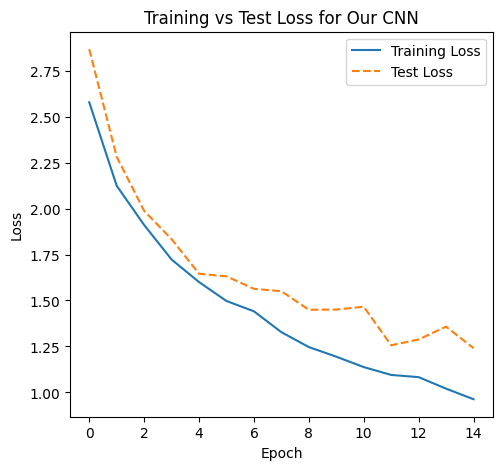

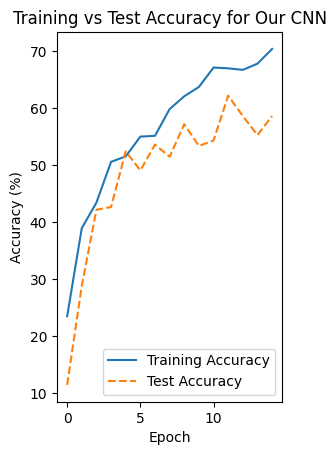

In [ ]:
# Define our own CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # input 128 x 128 x 3

        # Layer 1
        self.conv1 = nn.Conv2d(3, 16, 3, padding='same')
        self.act = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16)
        self.mp1 = nn.MaxPool2d(2, 2)  # output: 64 x 64 x 16

        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, 3, padding='same')
        self.dropout1 = nn.Dropout(0.2)
        self.bn2 = nn.BatchNorm2d(32)
        # output: 32 x 32 x 32

        # Layer 3
        self.conv3 = nn.Conv2d(32, 64, 3, padding='same')
        self.bn3 = nn.BatchNorm2d(64)
        # output: 16 x 16 x 64

        # Layer 4
        self.conv4 = nn.Conv2d(64, 128, 3, padding='same')
        self.bn4 = nn.BatchNorm2d(128)
        # output: 8 x 8 x 128

        # Classification
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, 21)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.mp1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)
        x = self.mp1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act(x)
        x = self.mp1(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.act(x)
        x = self.dropout1(x)
        x = self.mp1(x)

        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


proposed_model = CNN()

# Move the model to the desired device (GPU/CPU)
proposed_model = proposed_model.to(device)

# Define components
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(proposed_model.parameters(), lr=1e-3, weight_decay=1e-4)

train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    proposed_model, train_loader, test_loader, criterion, optimizer, num_epochs=15
)

plot_loss('Our CNN', train_losses, test_losses)
plot_acc('Our CNN', train_accuracies, test_accuracies)

---

# 3. **Evaluate models**

Here, you need to:

1.	evaluate the model (the best one you obtained in the above stage) on the testing dataset.


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

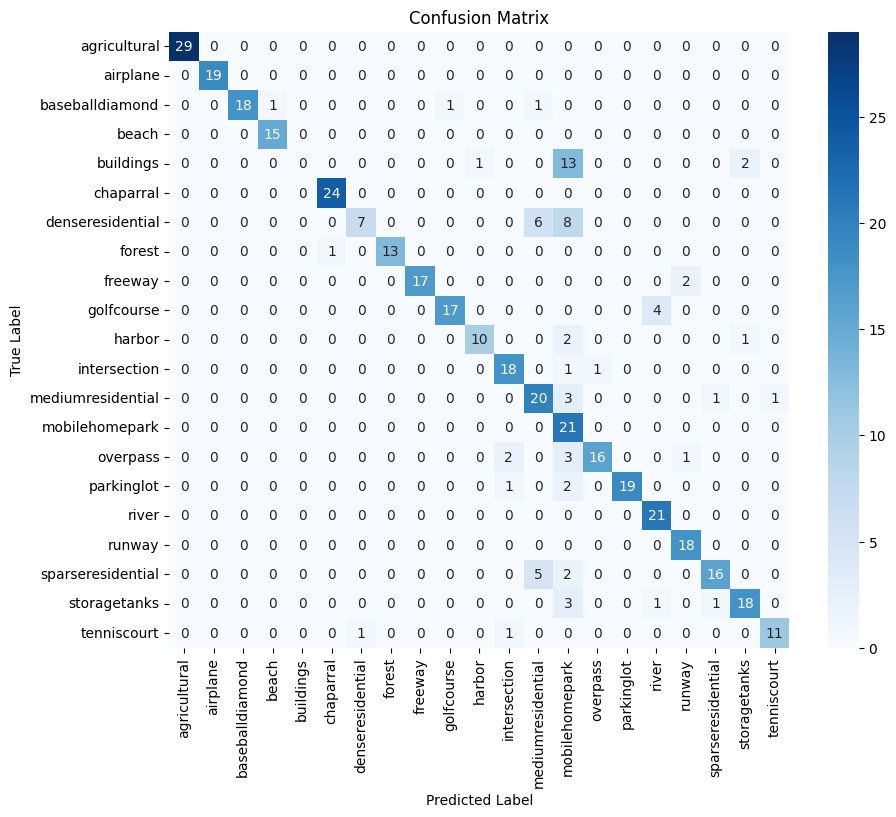

                   precision    recall  f1-score    support
agricultural        1.000000  1.000000  1.000000   29.00000
airplane            1.000000  1.000000  1.000000   19.00000
baseballdiamond     1.000000  0.857143  0.923077   21.00000
beach               0.937500  1.000000  0.967742   15.00000
buildings           0.000000  0.000000  0.000000   16.00000
chaparral           0.960000  1.000000  0.979592   24.00000
denseresidential    0.875000  0.333333  0.482759   21.00000
forest              1.000000  0.928571  0.962963   14.00000
freeway             1.000000  0.894737  0.944444   19.00000
golfcourse          0.944444  0.809524  0.871795   21.00000
harbor              0.909091  0.769231  0.833333   13.00000
intersection        0.818182  0.900000  0.857143   20.00000
mediumresidential   0.625000  0.800000  0.701754   25.00000
mobilehomepark      0.362069  1.000000  0.531646   21.00000
overpass            0.941176  0.727273  0.820513   22.00000
parkinglot          1.000000  0.863636  

In [ ]:
# Function to evaluate the model and generate reports
def evaluate_model_with_metrics(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds, zero_division=0)
    
    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True, zero_division=0)
    
    # Convert classification report to DataFrame
    df_report = pd.DataFrame(report).transpose()
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    return df_report

# Call the function
class_names = dataset.classes
df_results = evaluate_model_with_metrics(ResNet_FT, test_loader, class_names, zero_division=0)

# Display results table
print(df_results)

